### Prerequisites

In [1]:
# Install required packages
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import networkx as nx
from networkx import grid_2d_graph
from datetime import date

from scipy.optimize import minimize, check_grad
from sklearn.linear_model import LinearRegression, LogisticRegression
from matplotlib.lines import Line2D

### Create nominal problem instance

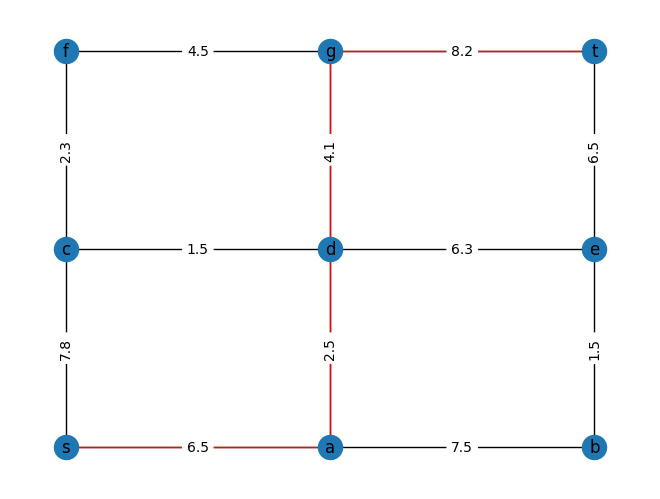

In [2]:
# Create instance for SPP
node_list = ['s', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 't']
edge_list = [("s", "a"), ("s", "c"), ("a", "b"), ("a", "d"),
             ("c", "d"), ("c", "f"), ("b", "e"), ("d", "e"),
             ("d", "g"), ("f", "g"), ("g", "t"), ("e", "t")]

SP_wgths_dct =  {("s", "a"): {"cost": 6.5}, ("s", "c"): {"cost": 7.8}, 
                 ("a", "b"): {"cost": 7.5}, ("a", "d"): {"cost": 2.5},
                 ("c", "d"): {"cost": 1.5}, ("c", "f"): {"cost": 2.3},
                 ("b", "e"): {"cost": 1.5}, ("d", "e"): {"cost": 6.3},
                 ("d", "g"): {"cost": 4.1}, ("f", "g"): {"cost": 4.5},
                 ("g", "t"): {"cost": 8.2}, ("e", "t"): {"cost": 6.5}}

G = nx.Graph()
G.add_nodes_from(node_list)
G.add_edges_from(edge_list)
nx.set_edge_attributes(G, SP_wgths_dct)

edge_labels = nx.get_edge_attributes(G, "cost")
pos = {"s":(0,0), "a":(1,0),"b":(2,0),"c":(0,1),"d":(1,1),"e":(2,1),"f":(0,2),"g":(1,2), "t":(2,2)}
sp = nx.shortest_path(G, "s", "t", weight='cost')
e_sp = list(zip(sp,sp[1:]))

# Plot instance of the graph
nx.draw(G, pos, with_labels = True)
nx.draw_networkx_edges(G, pos, edgelist=e_sp, edge_color="r")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

# Create a perturbation vector
SP_prtb_dct = {("s", "a"): {"cost": 0.5}, ("s", "c"): {"cost": 1.75}, 
                ("a", "b"): {"cost": 0.5},  ("a", "d"): {"cost": 0.5},
                ("c", "d"): {"cost": 0.7},  ("c", "f"): {"cost": 0.25},
                ("b", "e"): {"cost": 0.5},  ("d", "e"): {"cost": 1.25},
                ("d", "g"): {"cost": 1.1},  ("f", "g"): {"cost": 0.5},
                ("g", "t"): {"cost": 1.15}, ("e", "t"): {"cost": 0.5}}

org_csts = np.zeros(len(edge_list))
prt_csts = np.zeros(len(edge_list))
for i in range(len(edge_list)):
    org_csts[i] = SP_wgths_dct[edge_list[i]]['cost']
    prt_csts[i] = SP_prtb_dct[edge_list[i]]['cost']

In [3]:
# Global variables
nr_edges = len(edge_list)
smple_sz = 1000
epsilon  = 10e-4
today = date.today()

# Implied variables
nr_trgts = nr_edges + 1
nr_ftres = 1
nr_ftres_intrcpt = nr_ftres + 1
features = [0]

# Set seed
np.random.seed(42)

In [4]:
# Solve nominal problem and print output
print('Instance shortest path costs:' , np.round(nx.shortest_path_length(G, "s", "t", weight='cost'), 4))

SPP_sol = nx.shortest_path(G, "s", "t", weight='cost')
print('Instance shortest path:', SPP_sol)

for edge in edge_list:
    if edge[0] in SPP_sol and edge[1] in SPP_sol:
        print(f'Decision variable {edge} value: 1')
    else:
        print(f'Decision variable {edge} value: 0')

Instance shortest path costs: 21.3
Instance shortest path: ['s', 'a', 'd', 'g', 't']
Decision variable ('s', 'a') value: 1
Decision variable ('s', 'c') value: 0
Decision variable ('a', 'b') value: 0
Decision variable ('a', 'd') value: 1
Decision variable ('c', 'd') value: 0
Decision variable ('c', 'f') value: 0
Decision variable ('b', 'e') value: 0
Decision variable ('d', 'e') value: 0
Decision variable ('d', 'g') value: 1
Decision variable ('f', 'g') value: 0
Decision variable ('g', 't') value: 1
Decision variable ('e', 't') value: 0


### Solver

In [5]:
def shortest_path_solver(vals, output = 'all', G_org = G, start = 's', end = 't'):
    """
    Solves paramatrized SPP and outputs the desired target
    
    Args:
        vals:   Cost values of edges
        output: What part of the target to return
        G_org:  Original graph with properties
        start:  Start node SPP
        end:    End node SPP
        
    Returns:
        target vector
    """

    G_loc = copy.deepcopy(G_org)
    SP_wgths_lcl = {}

    for i in range(len(edge_list)):
        SP_wgths_lcl[edge_list[i]] = {}
        SP_wgths_lcl[edge_list[i]]['cost'] = vals[i]

    nx.set_edge_attributes(G_loc, SP_wgths_lcl)

    if output == 'all':
        solutions = []
        solutions.append(nx.shortest_path_length(G_loc, start, end, weight='cost'))
        SPP_sol = nx.shortest_path(G_loc, start, end, weight='cost')
        for edge in edge_list:
            if edge[0] in SPP_sol and edge[1] in SPP_sol:
                solutions.append(1)
            else:
                solutions.append(0)
        return solutions

    elif output == 'bounded' or output == 'feasibility':
        return vals.all() > 0
    
    elif output == 'path':
        return nx.shortest_path(G_loc, start, end, weight='cost')
    
    elif output == 'objective':
        return nx.shortest_path_length(G_loc, start, end, weight='cost')
    
    else:
        raise ValueError("Output not supported for model function")

### Constraints

In [6]:
# Measure the violation of the flow constraints using the decision vector
def flow_constraints(x):
    constr_lst = []
    constr_lst.append(x[:,0]+x[:,1]-np.ones(np.shape(x[:,0])))
    constr_lst.append(x[:,0]-x[:,2]-x[:,3])
    constr_lst.append(x[:,1]-x[:,4]-x[:,5])
    constr_lst.append(x[:,2]-x[:,6])
    constr_lst.append(x[:,3]+x[:,4]-x[:,7]-x[:,8])
    constr_lst.append(x[:,6]+x[:,7]-x[:,11])
    constr_lst.append(x[:,5]-x[:,9])
    constr_lst.append(x[:,8]+x[:,9]-x[:,10])
    constr_lst.append(x[:,10]+x[:,11]-np.ones(np.shape(x[:,0])))
    return np.transpose(np.array(constr_lst))


# Help function to determine the Jacobian of the loss due to flow 
# constraint violation
def jac_flow_constraints(x):
    # Define matrix of indicators indicating which decision variable
    # is in which constraint with which parity
    indicators = np.array([ [1,1,0,0,0,0,0,0,0],  [1,0,1,0,0,0,0,0,0],
                            [0,-1,0,1,0,0,0,0,0], [0,-1,0,0,1,0,0,0,0],
                            [0,0,-1,0,1,0,0,0,0], [0,0,-1,0,0,0,1,0,0],
                            [0,0,0,-1,0,1,0,0,0], [0,0,0,0,-1,1,0,0,0],
                            [0,0,0,0,-1,0,0,1,0], [0,0,0,0,0,0,-1,1,0],
                            [0,0,0,0,0,0,0,-1,1], [0,0,0,0,0,-1,0,0,1]])
    indicators = np.transpose(indicators)
    constr_lst = flow_constraints(x)
    jac_flow_lst = np.matmul(constr_lst, indicators)
    return jac_flow_lst

### Experiment: explain full target

### Dataset creation

In [7]:
# Set of help function to create a sample train set for the model

# Get values from samples
def get_values_from_samples(smpls, model_lcl, hyperprm = {}):
    values = []
    for smpl in smpls:
        values.append(model_lcl(smpl, **hyperprm))
    return values

# Determine weight of samples
def std_weight_function(a, b, kernel_width = None):
    d = np.linalg.norm(a - b)
    if kernel_width is None:
        krnl_wdth = 0.75 
    else:
        krnl_wdth = kernel_width
    return np.exp(-(d ** 2) / (2* krnl_wdth ** 2))
    
def get_weights_from_samples(smpls, function = None, width = None):
    org = smpls[0]
    weights = []
    for smpl in smpls:
        if function is not None:
            weights.append(function(org, smpl))
        else:
            weights.append(std_weight_function(org, smpl, width))
    return weights

In [8]:
# Sigmoid function for logistic regression
def sig(x):
    safe_x = np.asarray(x)  
    result = np.empty_like(safe_x, dtype=float)
    
    # Cap off sigmoid function outside [-30,30]
    result[safe_x > 30]  = 1
    result[safe_x < -30] = 0
    mask = (safe_x >= -30) & (safe_x <= 30)
    result[mask] = 1 / (1 + np.exp(-safe_x[mask]))

    return result

# Help function for the log loss computation
# Calculates ln(pred(y))
def lg1(x):
    safe_x = np.asarray(x) 
    result = np.empty_like(safe_x, dtype=float)
    
    # Account for cap off sigmoid function outside [-30,30]
    result[safe_x > 30]  = 0
    result[safe_x < -30] = np.log(1 / (1 + np.exp(30)))
    mask = (safe_x >= -30) & (safe_x <= 30)
    result[mask] = np.log(1 / (1 + np.exp(-safe_x[mask])))

    return result

# Help function for the log loss computation
# Calculates ln(1-pred(y))
def lg2(x):
    safe_x = np.asarray(x)  
    result = np.empty_like(safe_x, dtype=float)
    
    # Account for cap off sigmoid function outside [-30,30]
    result[safe_x < -30] = 0
    result[safe_x > 30]  = np.log(1 - 1 / (1 + np.exp(-30)))
    mask = (safe_x >= -30) & (safe_x <= 30)
    result[mask] = np.log(1 - (1 / (1 + np.exp(-safe_x[mask]))))
    
    return result

In [9]:
# Create dataset to train model on

# Compute samples (theta)
lmb_smpls = np.sort(np.concatenate(([0], np.random.uniform(-1,1,smple_sz-1))))
samples = [[item, 1.0] for item in lmb_smpls] #Samples with intercept variable

# Compute Eucl. distances to nominal problem (d_list)
# Compute cost vector for each sample (cst_smpls)
d_list = []
cst_smpls = []
for i in range(smple_sz):
    cst_smpls.append(org_csts+ lmb_smpls[i]*prt_csts)
    d_list.append(np.linalg.norm(lmb_smpls[0] - lmb_smpls[i]))

# Compute targets (actuals) and weights
actuals = get_values_from_samples(cst_smpls, shortest_path_solver, hyperprm = {'output':'all'})
weights = get_weights_from_samples(lmb_smpls, width=np.mean(d_list))

# Set cost matrix for matrix multiplications later on
Cost_matrix = np.array(cst_smpls)

In [10]:
# Set which components of decision vector to explain
all_trgs = [*range(12)] #explain all decision variables

### Loss functions

In [11]:
def lss_all(beta, X = samples, Y = actuals, W = weights, lgr_std = 1, lgr_log = 1, lgr_obj = 1, lgr_cns = 1, oneD=True, C = Cost_matrix, keep_columns=all_trgs):
    """
    Functions for the total empircal loss at surrogates/explanations using beta parameters

    Args:
        beta:           Beta parameter for surrogate model
        X:              Parameters (incl. intercept) of sample data set (dim(sample size, #features + 1))
        Y:              Targets of sample data set (dim(sample size, 1 + #decision variables))
        W:              Weights of the samples (dim(sample size))
        lgr_...:        Scalar for various components of total loss
        oneD:           Boolean whether beta is passed on as an one-dim vector (True) or as a matrix (False)
        C:              Cost matrix to calculate objective using decision vector (dim(sample size, #decision variables))
        keep_columns:   Indices of decision vector to keep to predict and calculate loss for
        
    Returns:
        tot_err:        Total weighted loss
    """

    # Transform beta to matrix for matrix calculations
    if oneD == True:
        beta = beta.reshape(nr_ftres_intrcpt, nr_trgts)

    W = np.array(W)
    X = np.array(X)
    Y = np.array(Y)
    Y_dcv = Y[:,1:]                     # Select only decision vector from actuals
    Y_dcv_kp = Y_dcv[:,keep_columns]    # Only calulate loss for the decision variables we predict
    
    obj_prd = np.matmul(X, beta)[:,0]                           # Predictions objective value
    dcv_prd = sig(np.matmul(X, beta))[:,1:]                     # Predictions decision vector
    dcv_lg1 = (lg1(np.matmul(X, beta)[:,1:]))[:,keep_columns]   # ln(Predictions decision vector)
    dcv_lg2 = (lg2(np.matmul(X, beta)[:,1:]))[:,keep_columns]   # ln(1 - Predictions decision vector)

    # Replace predictions with actuals for decision variables not in keep_columns, not explained
    all_columns = set(range(nr_trgts-1))
    replace_columns = list(all_columns - set(keep_columns))
    dcv_prd_keep = dcv_prd.copy()
    dcv_prd_keep[:, replace_columns] = Y_dcv[:, replace_columns]

    cns_arr = flow_constraints(dcv_prd_keep)    # Constraint error
    
    # Calculate various weighted losses
    std_err = np.sum(np.matmul(np.diag(W), np.square(Y[:,0] - obj_prd)))
    log_err = -np.sum(np.matmul(np.diag(W),(np.multiply(Y_dcv_kp,dcv_lg1)+np.multiply((np.ones(np.shape(dcv_lg2))-Y_dcv_kp),dcv_lg2))))
    obj_err = np.sum(np.matmul(np.diag(W),np.square(obj_prd-np.sum(np.multiply(dcv_prd_keep, C), axis=1))))
    cns_err = np.sum(np.matmul(np.diag(W),np.square(cns_arr)))

    # Weighted sum of the various losses
    tot_err = lgr_std * std_err + lgr_cns * cns_err + lgr_log * log_err + lgr_obj * obj_err
    return tot_err


def lss_all_jac_sg(beta, X = samples, Y = actuals, W = weights, lgr_std = 1, lgr_log = 1, lgr_obj = 1, lgr_cns = 1, oneD=True, C = Cost_matrix, keep_columns=all_trgs):
    """
    Functions that outputs Jacobian/subgradient of lss_all function at beta

    Args:
        beta:           Beta parameter for surrogate model
        X:              Parameters (incl. intercept) of sample data set (dim(sample size, #features + 1))
        Y:              Targets of sample data set (dim(sample size, 1 + #decision variables))
        W:              Weights of the samples (dim(sample size))
        lgr_...:        Scalar for various components of total loss
        oneD:           Boolean whether beta is passed on as an one-dim vector (True) or as a matrix (False)
        C:              Cost matrix to calculate objective using decision vector (dim(sample size, #decision variables))
        keep_columns:   Indices of decision vector to keep to predict and calculate loss for
        
    Returns:
        grad_flat: One-dimensional Jacobian/subgradient of lss_all function at beta
    """

    grad = np.zeros((nr_ftres_intrcpt, nr_trgts))       # Initialize gradient as zero-vector
    
    # Transform beta to matrix for matrix calculations
    if oneD == True:
        beta = beta.reshape(nr_ftres_intrcpt, nr_trgts)

    W = np.array(W)
    X = np.array(X)
    Y = np.array(Y)
    Y_dcv = Y[:,1:]     # Select only decision vector from actuals

    obj_prd = np.matmul(X, beta)[:,0]           # Predictions objective value
    dcv_prd = sig(np.matmul(X, beta)[:,1:])     # Predictions decision vector

    # Replace predictions with actuals for decision variables not in keep_columns, not explained
    all_columns = set(range(nr_trgts-1))
    replace_columns = list(all_columns - set(keep_columns))
    dcv_prd_keep = dcv_prd.copy()
    dcv_prd_keep[:, replace_columns] = Y_dcv[:, replace_columns]

    # Vectors containing chain rule factors for gradient of different errors
    tmp_std = (Y[:,0]  - obj_prd)
    tmp_obj = (obj_prd - np.sum(np.multiply(dcv_prd_keep,C), axis=1))
    tmp_cns = jac_flow_constraints(dcv_prd_keep)

    for k in range(len(grad)):
        for j in range(len(grad[0])):
            if j == 0:                  # objective value
                grad[k][j] = grad[k][j] - 2 * lgr_std * (sum(W[i] * X[i][k] * tmp_std[i] for i in range(len(X))))   # accuracy error
                grad[k][j] = grad[k][j] + 2 * lgr_obj * (sum(W[i] * X[i][k] * tmp_obj[i] for i in range(len(X))))   # coherence objective error
            elif j-1 in keep_columns:   # decision vector
                grad[k][j] = grad[k][j] - lgr_log * (np.abs(beta[k][j])<30 )*(sum(W[i] * X[i][k] * (Y[i][j]-dcv_prd[i][j-1]) for i in range(len(X))))                   # accuracy error
                grad[k][j] = grad[k][j] - 2 * lgr_obj * (sum(dcv_prd[i][j-1] * (1-dcv_prd[i][j-1]) * X[i][k] * C[i][j-1] * W[i] * tmp_obj[i] for i in range(len(X))))   # coherence objective error
                grad[k][j] = grad[k][j] + 2 * lgr_cns * (sum(dcv_prd[i][j-1] * (1-dcv_prd[i][j-1]) * X[i][k] * W[i] * tmp_cns[i][j-1] for i in range(len(X))))          # coherence feasibile region error
    grad_flat = grad.flatten()  # make one-dimensional
    return grad_flat

In [12]:
"""
Functions for the four components of the loss function seperately

Args:
    beta:   beta parameter for surrogate model
    X:              Parameters (incl. intercept) of sample data set (dim(sample size, #features + 1))
    Y:              Targets of sample data set (dim(sample size, 1 + #decision variables))
    W:              Weights of the samples (dim(sample size))
    oneD:           Boolean whether beta is passed on as an one-dim vector (True) or as a matrix (False)
    C:              Cost matrix to calculate objective using decision vector (dim(sample size, #decision variables))
    keep_columns:   Indices of decision vector to keep to predict and calculate loss for
    
Returns:
    Loss values
"""

# Accuracy loss of objective value: weighted squared loss
def lss_std(beta, X = samples, Y = actuals, W = weights, oneD=True):
    if oneD == True:
        beta = beta.reshape(nr_ftres_intrcpt, nr_trgts)
    W = np.array(W)
    X = np.array(X)
    Y = np.array(Y)
    return np.sum(np.matmul(np.diag(W),np.square(Y[:,0] - np.matmul(X, beta)[:,0])))

# Accuracy loss of decision vector: weighted log loss
def lss_log(beta, X = samples, Y = actuals, W = weights, oneD=True, keep_columns=all_trgs):
    if oneD == True:
        beta = beta.reshape(nr_ftres_intrcpt, nr_trgts)
    W = np.array(W)
    X = np.array(X)
    Y = np.array(Y)
    Y_dcv = Y[:,1:]                     # Select only decision vector from actuals
    Y_dcv_kp = Y_dcv[:,keep_columns]    # Only calulate loss for the variables we predict
    dcv_lg1 = lg1(np.matmul(X, beta)[:,1:])[:,keep_columns]
    dcv_lg2 = lg2(np.matmul(X, beta)[:,1:])[:,keep_columns]
    return -np.sum(np.matmul(np.diag(W),(np.multiply(Y_dcv_kp,dcv_lg1)+np.multiply((np.ones(np.shape(dcv_lg2))-Y_dcv_kp),dcv_lg2))))

# Coherency loss for objective value: weighted squared loss
def lss_obj(beta, X = samples, Y = actuals, W = weights, oneD=True, C = Cost_matrix, keep_columns=all_trgs):
    if oneD == True:
        beta = beta.reshape(nr_ftres_intrcpt, nr_trgts)
    W = np.array(W)
    X = np.array(X)
    Y = np.array(Y)
    Y_dcv = Y[:,1:]     # Select only decision vector from actuals

    # Replace predictions with actuals for decision variables not in keep_columns, not explained
    all_columns = set(range(nr_trgts-1))
    replace_columns = list(all_columns - set(keep_columns))
    dcv_prd = sig(np.matmul(X, beta)[:,1:])
    dcv_prd_keep = dcv_prd.copy()
    dcv_prd_keep[:, replace_columns] = Y_dcv[:, replace_columns]

    return np.sum(np.matmul(np.diag(W),np.square(np.matmul(X, beta)[:,0]-np.sum(np.multiply(dcv_prd_keep, C), axis=1))))

# Coherency loss for feasible region: weighted squared loss
def lss_cns(beta, X = samples, Y = actuals, W = weights, oneD=True, keep_columns=all_trgs):
    if oneD == True:
        beta = beta.reshape(nr_ftres_intrcpt, nr_trgts)
    W = np.array(W)
    X = np.array(X)
    Y = np.array(Y)
    Y_dcv = Y[:,1:]     # Select only decision vector from actuals

    # Replace predictions with actuals for decision variables not in keep_columns, not explained
    all_columns = set(range(nr_trgts-1))
    replace_columns = list(all_columns - set(keep_columns))
    dcv_prd = sig(np.matmul(X, beta)[:,1:])
    dcv_prd_keep = dcv_prd.copy()
    dcv_prd_keep[:, replace_columns] = Y_dcv[:, replace_columns]

    cns_arr = flow_constraints(dcv_prd_keep)
    return np.sum(np.matmul(np.diag(W),np.square(cns_arr)))

### Warm start

In [64]:
def get_warm_start_reg(X, Y, W):
    """
    Obtain a warm start for finding surrogate models (minimizing lss_all) 
    using regression models without any regulazers

    Args:
        X:          Parameters (excl. intercept) of sample data set (dim(#features, sample size))
        Y:          Targets of sample data set (dim(1 + #decision variables, sample size))
        W:          Weights of the samples (dim(sample size))
        
    Returns:
        wrm_strt:   Model parameters of standard regression models (dim(#features + 1, #targets))
    """
    models = []
    for i in range(len(Y[0])):
        Y_loc = [x[i] for x in Y] 

        # Objective: use LinearRegression
        if i == 0:
            clf = LinearRegression()
            clf.fit(X.reshape(-1, 1), Y_loc, sample_weight = W)

        # Decision variables: binary, use LinearRegression if
        # samples contain both 0 and 1 values, fix parameters otherwise
        elif np.sum(Y_loc) == len(Y_loc):
            clf = 'All 1'
        elif np.sum(Y_loc) == 0:
            clf = 'All 0'
        else:
            clf = LogisticRegression()
            Y_loc_int = [int(item) for item in Y_loc]
            clf.fit(X.reshape(-1, 1), Y_loc_int, sample_weight = W)
        models.append(clf)

    # extract parameters from fitted models
    wrm_strt_t = np.zeros((len(Y[0]), len(features)+1))
    for i in range(len(models)):
        if models[i] == 'All 1':        # fix parameters when dcsn var only one value in dataset
            wrm_strt_t[i][j+1] = 30
        elif models[i] == 'All 0':      # fix parameters when dcsn var only one value in dataset
            wrm_strt_t[i][j+1] = -30
        elif any(isinstance(item, np.ndarray) for item in models[i].coef_):
            for j in range(len(features)):
                wrm_strt_t[i][j] = models[i].coef_[0][j]
            wrm_strt_t[i][j+1] = models[i].intercept_[0]
        else:
            for j in range(len(features)):
                wrm_strt_t[i][j] = models[i].coef_[j]
            wrm_strt_t[i][j+1] = models[i].intercept_
    wrm_strt = np.transpose(wrm_strt_t)
    return wrm_strt

import time
start_time = time.time()
wrm_strt_lcl = get_warm_start_reg(np.array(lmb_smpls), actuals, weights)
end_time = time.time()
print('Time taken for optimization:', end_time - start_time)

Time taken for optimization: 0.018999814987182617


In [14]:
# Calculate all losses with warm start parameters
lcl_lss_all = lss_all(wrm_strt_lcl, X = samples, Y = actuals, W =weights)
lcl_lss_std = lss_std(wrm_strt_lcl, X = samples, Y = actuals, W =weights)
lcl_lss_log = lss_log(wrm_strt_lcl, X = samples, Y = actuals, W =weights)
lcl_lss_obj = lss_obj(wrm_strt_lcl, X = samples, Y = actuals, W =weights)
lcl_lss_cns = lss_cns(wrm_strt_lcl, X = samples, Y = actuals, W =weights)

In [15]:
# Check the correctness of a gradient function by comparing it against a (forward) finite-difference approximation of the gradient.
print('Error jacobian using subgradient: ', check_grad(lss_all, lss_all_jac_sg, wrm_strt_lcl.flatten()))

Error jacobian using subgradient:  0.007525667511657424


In [16]:
# Set functions to call loss function + gradient for set weights for different losses
def lss_all_input(input, lmb_1, lmb_2, lmb_3, lmb_4):
    return lss_all(beta = input, lgr_std=lmb_1, lgr_log=lmb_2, lgr_obj=lmb_3, lgr_cns=lmb_4)

def lss_all_jac_input(input, lmb_1, lmb_2, lmb_3, lmb_4):
    return lss_all_jac_sg(beta = input, lgr_std=lmb_1, lgr_log=lmb_2, lgr_obj=lmb_3, lgr_cns=lmb_4)

In [17]:
# Set scalars based on warm start to balance various losses
lss_list  = [lcl_lss_std, lcl_lss_log, lcl_lss_obj, lcl_lss_cns]
max_lss_i = np.argmax(lss_list) 

lmb_lst = np.ones(4)
for i in range(4):
    if max_lss_i != i and lss_list[i] >0.01:
        lmb_lst[i] = 0.5 * lss_list[max_lss_i]/lss_list[i]

args_RLR = (lmb_lst[0], lmb_lst[1], lmb_lst[2], lmb_lst[3])

### Minimize loss function

In [60]:
# Minimize loss function
import time
start_time = time.time()
wrm_start_lcl = wrm_strt_lcl.flatten()
sol_RLR_lcl = minimize(lss_all_input, wrm_start_lcl, args = args_RLR, method='SLSQP', jac=lss_all_jac_input, options = {'maxiter': 1000})
print(sol_RLR_lcl)
end_time = time.time()
print('Time taken for optimization:', end_time - start_time)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1151.933442749224
       x: [ 3.893e+00  1.325e+01 ...  6.810e+00 -7.402e+00]
     nit: 36
     jac: [-1.019e-02  6.851e-04 ...  5.971e-03  7.809e-03]
    nfev: 78
    njev: 36
Time taken for optimization: 3.1078741550445557


#### Different warm starts

In [61]:
start_time = time.time()
wrm_start_lcl_0 = np.zeros_like(wrm_strt_lcl.flatten())
sol_RLR_lcl_0 = minimize(lss_all_input, wrm_start_lcl_0, args = args_RLR, method='L-BFGS-B', jac=lss_all_jac_input, options = {'maxiter': 100000})
print(sol_RLR_lcl_0)
end_time = time.time()
print('Time taken for optimization:', end_time - start_time)

start_time = time.time()
wrm_start_lcl_1 = np.ones_like(wrm_strt_lcl.flatten())
sol_RLR_lcl_1 = minimize(lss_all_input, wrm_start_lcl_1, args = args_RLR, method='L-BFGS-B', jac=lss_all_jac_input, options = {'maxiter': 100000})
print(sol_RLR_lcl_1)
end_time = time.time()
print('Time taken for optimization:', end_time - start_time)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1138.9951126841179
        x: [ 3.898e+00  1.339e+01 ...  6.965e+00 -8.650e+00]
      nit: 1010
      jac: [ 2.434e-02  5.538e-03 ...  1.414e-02  6.787e-03]
     nfev: 1102
     njev: 1102
 hess_inv: <26x26 LbfgsInvHessProduct with dtype=float64>
Time taken for optimization: 92.30444383621216
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1138.994645371462
        x: [ 3.898e+00  1.338e+01 ...  6.955e+00 -8.631e+00]
      nit: 1220
      jac: [ 6.224e-02  1.290e-02 ...  2.575e-02  5.348e-03]
     nfev: 1345
     njev: 1345
 hess_inv: <26x26 LbfgsInvHessProduct with dtype=float64>
Time taken for optimization: 110.14846706390381


In [65]:
random_init = {}
random_time = []
for i in range(10):
    start_time = time.time()
    wrm_start_lcl_rd = np.random.uniform(-10,10, size=len(wrm_strt_lcl.flatten()))
    sol_RLR_lcl_rd = minimize(lss_all_input, wrm_start_lcl_rd, args = args_RLR, method='L-BFGS-B', jac=lss_all_jac_input, options = {'maxiter': 100000})
    print(sol_RLR_lcl_rd)
    end_time = time.time()
    print('Time taken for optimization:', end_time - start_time)
    random_init[i] = sol_RLR_lcl_rd
    random_time.append(end_time - start_time)


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1132.978179263502
        x: [ 3.885e+00  1.348e+01 ...  6.968e+00 -8.652e+00]
      nit: 1277
      jac: [ 8.896e-03 -1.235e-02 ...  3.017e-03 -1.358e-02]
     nfev: 1411
     njev: 1411
 hess_inv: <26x26 LbfgsInvHessProduct with dtype=float64>
Time taken for optimization: 118.67418265342712
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1143.842541769524
        x: [ 3.876e+00  1.331e+01 ...  6.811e+00 -7.400e+00]
      nit: 1256
      jac: [ 1.347e-02 -1.074e-02 ...  1.033e-02  1.820e-02]
     nfev: 1385
     njev: 1385
 hess_inv: <26x26 LbfgsInvHessProduct with dtype=float64>
Time taken for optimization: 122.51551914215088
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1139.0015331589289
        x: [ 3.898e+00  1.343e+01 ...  6.967e+00 -8.656e+00]
      nit: 1033
      jac: [-1.356e

In [ ]:
print('Total loss with scalars:')
print('Benchmark:', lss_all(wrm_start_lcl, lgr_std=args_RLR[0], lgr_log=args_RLR[1], lgr_obj=args_RLR[2], lgr_cns=args_RLR[3]))
print('New method:', lss_all(sol_RLR_lcl.x, lgr_std=args_RLR[0], lgr_log=args_RLR[1], lgr_obj=args_RLR[2], lgr_cns=args_RLR[3]))#, '\n')
print('New method 0:', lss_all(sol_RLR_lcl_0.x, lgr_std=args_RLR[0], lgr_log=args_RLR[1], lgr_obj=args_RLR[2], lgr_cns=args_RLR[3]))#, '\n')
print('New method 1:', lss_all(sol_RLR_lcl_1.x, lgr_std=args_RLR[0], lgr_log=args_RLR[1], lgr_obj=args_RLR[2], lgr_cns=args_RLR[3]), '\n')



print('Objective value prediction error:')
print('Benchmark,', lss_std(wrm_start_lcl))
print('New method,', lss_std(sol_RLR_lcl.x))#, '\n')
print('New method 0,', lss_std(sol_RLR_lcl_0.x))#, '\n')
print('New method 1,', lss_std(sol_RLR_lcl_1.x), '\n')

print('Decision vector prediction error:')
print('Benchmark,', lss_log(wrm_start_lcl))
print('New method,', lss_log(sol_RLR_lcl.x))#, '\n')
print('New method 0,', lss_log(sol_RLR_lcl_0.x))#, '\n')
print('New method 1,', lss_log(sol_RLR_lcl_1.x), '\n')

print('Objective value relation error:')
print('Benchmark,', lss_obj(wrm_start_lcl))
print('New method,', lss_obj(sol_RLR_lcl.x))#, '\n')
print('New method 0,', lss_obj(sol_RLR_lcl_0.x))#, '\n')
print('New method 1,', lss_obj(sol_RLR_lcl_1.x), '\n')

print('Flow constraint error:')
print('Benchmark,', lss_cns(wrm_start_lcl))
print('New method,', lss_cns(sol_RLR_lcl.x))#, '\n')
print('New method 0,', lss_cns(sol_RLR_lcl_0.x))#, '\n')
print('New method 1,', lss_cns(sol_RLR_lcl_1.x), '\n')

Total loss with scalars:
Benchmark: 1620.1532428477012
New method: 1151.933442749224
New method 0: 1138.9951126841179
New method 1: 1138.994645371462 

Objective value prediction error:
Benchmark, 32.030734593247175
DTR, 17.034958343245542
New method, 32.11985528820192
New method 0, 32.15080077712341
New method 1, 32.15075658003823 

Decision vector prediction error:
Benchmark, 648.0612971390805
DTR 7178.820458734943
New method, 646.2771343217127
New method 0, 658.8544776149708
New method 1, 658.89343247393 

Objective value relation error:
Benchmark, 112.5150165973684
DTR, 17.034958343245542
New method, 6.907885029487659
New method 0, 9.120364805628377
New method 1, 9.098961523810406 

Flow constraint error:
Benchmark, 54.55485310873564
DTR 0.0
New method, 27.077888111413454
New method 0, 21.6565208473864
New method 1, 21.660336630689656 



In [66]:
for i in range(10):
    print(f'Random {i}. Objective value prediction error: {lss_std(random_init[i].x):2F}')
    print(f'Random {i}. Decision vector prediction error: {lss_log(random_init[i].x):2F}')
    print(f'Random {i}. Objective value relation error: {lss_obj(random_init[i].x):2F}')
    print(f'Random {i}. Flow constraint error: {lss_cns(random_init[i].x):2F}')
    print(f'Random {i}. Time taken: {random_time[i]:2F}')

Random 0. Objective value prediction error: 32.079049
Random 0. Decision vector prediction error: 662.620079
Random 0. Objective value relation error: 5.637665
Random 0. Flow constraint error: 21.820356
Random 0. Time taken: 118.674183
Random 1. Objective value prediction error: 32.041877
Random 1. Decision vector prediction error: 650.397305
Random 1. Objective value relation error: 2.933737
Random 1. Flow constraint error: 27.081740
Random 1. Time taken: 122.515519
Random 2. Objective value prediction error: 32.150250
Random 2. Decision vector prediction error: 658.591847
Random 2. Objective value relation error: 9.135758
Random 2. Flow constraint error: 21.695293
Random 2. Time taken: 101.179768
Random 3. Objective value prediction error: 32.046846
Random 3. Decision vector prediction error: 650.200495
Random 3. Objective value relation error: 3.378683
Random 3. Flow constraint error: 27.209928
Random 3. Time taken: 85.608678
Random 4. Objective value prediction error: 32.110700
Ran

In [22]:
# Retrieve solution and predictions
beta_sol = sol_RLR_lcl.x.reshape(nr_ftres_intrcpt, nr_trgts)
obj_prd = np.matmul(samples, beta_sol)[:,0]
obj_act = np.array(actuals)[:,0]

### Plot results

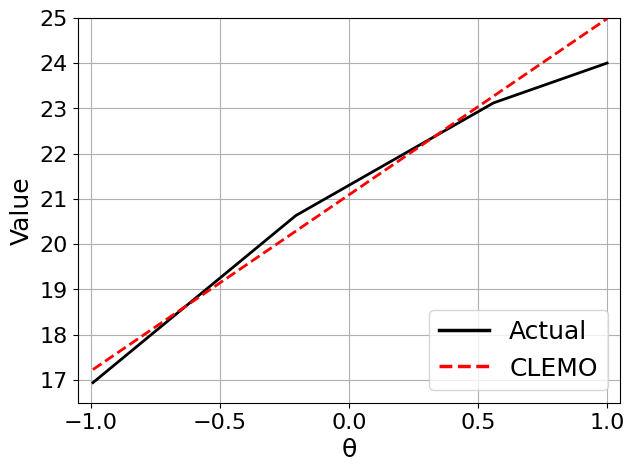

In [23]:
# Plot objective prediction
fig = plt.figure(figsize=(7,5))
plt.rcParams.update({
    'font.size': 18,              # Base font size
    'axes.labelsize': 18,         # Axis label size
    'xtick.labelsize': 16,        # X-tick label size
    'ytick.labelsize': 16,        # Y-tick label size
    'legend.fontsize': 18,        # Legend text size
})
sns.lineplot(x=lmb_smpls, y=obj_act, 
                color='Black',
                linestyle='-',    # solid line
                linewidth=2)      # thicker line
    

sns.lineplot(x=lmb_smpls, y=obj_prd,
                color='Red',
                linestyle='--',   # dashed line
                linewidth=2)    # medium thickness

legend_elements = [
    Line2D([0], [0], color='Black', linestyle='-', 
           linewidth=2.5, label='Actual'),
    Line2D([0], [0], color='Red', linestyle='--', 
           linewidth=2.5, label='CLEMO')
]

ax = plt.gca()
ax.grid(True)
# Add a single legend to the figure
plt.legend(handles=legend_elements, 
            loc='lower right' )  # Fine-tune the position
plt.xlabel("\u03B8")
plt.ylabel("Value") 
plt.xlim(-1.05, 1.05)    # Set x-axis limits
plt.ylim(16.5, 25)   # Set y-axis limits
# plt.title("Objective value prediction")

plt.gca().set_xticks(np.arange(-1, 1.1, 0.5))    # Every 2 units
plt.gca().set_yticks(np.arange(17, 25.1, 1))   # Every 2 units
plt.show()

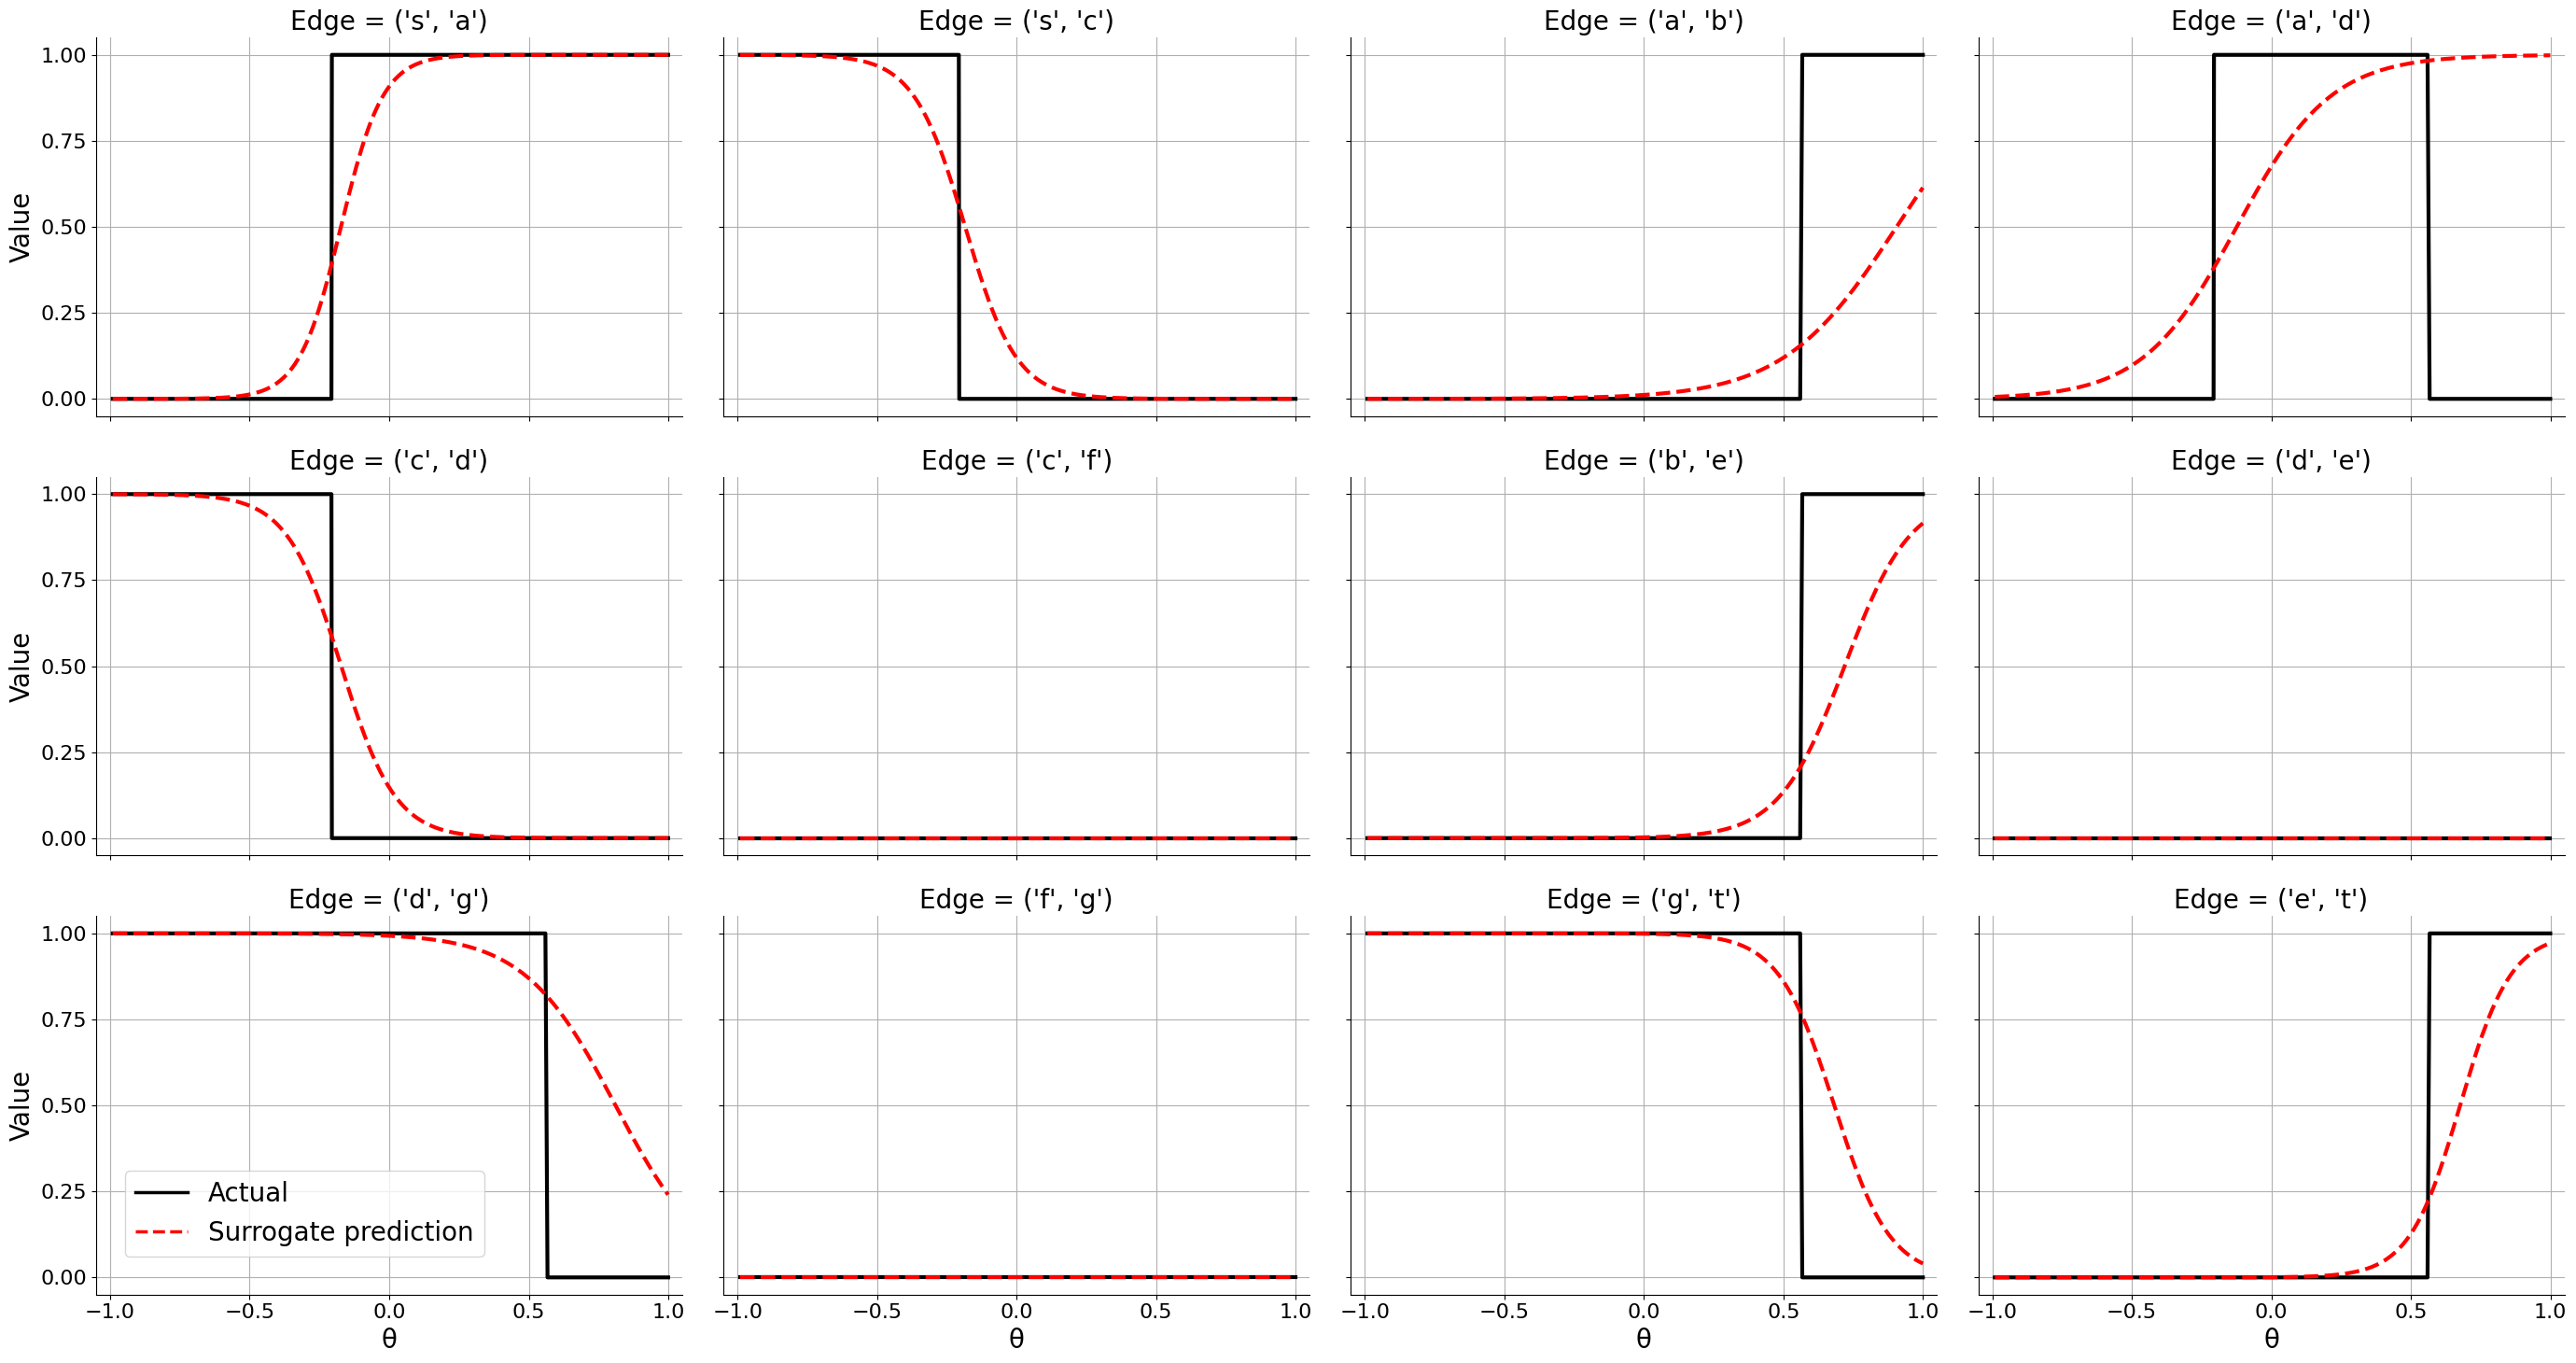

In [24]:
# Plot predictions decision variables in grid
data = []
plot_data = {}

plt.rcParams.update({
    'font.size': 20,              # Base font size
    'axes.labelsize': 20,         # Axis label size
    'xtick.labelsize': 16,        # X-tick label size
    'ytick.labelsize': 16,        # Y-tick label size
    'legend.fontsize': 20,        # Legend text size
})

# Generate data for each plot
for indx in all_trgs:
    edge = str(edge_list[indx])
    x0_prd = sig(np.matmul(samples, beta_sol)[:,indx+1])
    x0_act = np.array(actuals)[:,indx+1]
    tuple = (x0_act, x0_prd)
    plot_data[edge] = tuple


# Create a long-format DataFrame
for plot_name, (line1, line2) in plot_data.items():
    # Add data for first line
    data.extend([
        {'\u03B8': x_val, 'Value': y_val, 'line': 'Actual', 'Edge': plot_name}
        for x_val, y_val in zip(lmb_smpls, line1)
    ])
    # Add data for second line
    data.extend([
        {'\u03B8': x_val, 'Value': y_val, 'line': 'Surrogate prediction', 'Edge': plot_name}
        for x_val, y_val in zip(lmb_smpls, line2)
    ])

# Convert to DataFrame
df = pd.DataFrame(data)

# Define custom color palette
custom_palette = {'Surrogate prediction': 'red',
                 'Actual': 'black'}     

# Create FacetGrid
g = sns.FacetGrid(df, col='Edge',
                  col_wrap=4, height=5, aspect = 1.4,
                  sharex=True, sharey=True)

# Custom plotting function to specify line styles
def plot_lines(data, x, y, hue, **kwargs):
    # Plot Line 1 with solid line and thickness of 2
    line1_data = data[data[hue] == 'Actual']
    sns.lineplot(data=line1_data, x=x, y=y, 
                color=custom_palette['Actual'],
                linestyle='-',    # solid line
                linewidth=3)      # thicker line
    
    # Plot Line 2 with dashed line and thickness of 1.5
    line2_data = data[data[hue] == 'Surrogate prediction']
    sns.lineplot(data=line2_data, x=x, y=y,
                color=custom_palette['Surrogate prediction'],
                linestyle='--',   # dashed line
                linewidth=3)    # medium thickness

# Map the custom plotting function
g.map_dataframe(plot_lines, x='\u03B8', y='Value', hue='line')

#  Create a single legend
legend_elements = [
    Line2D([0], [0], color=custom_palette['Actual'], linestyle='-', 
           linewidth=2.5, label='Actual'),
    Line2D([0], [0], color=custom_palette['Surrogate prediction'], linestyle='--', 
           linewidth=2.5, label='Surrogate prediction')
]

# Add a single legend to the figure
g.fig.legend(handles=legend_elements, 
            loc='lower left' , bbox_to_anchor=(0.05, 0.08))  # Fine-tune the position

g.set(xlim=(-1.05, 1.05),    # Set x-axis limits
      ylim=(-0.05, 1.05))    # Set y-axis limits

ax = plt.gca()
ax.grid(True)

plt.gca().set_xticks(np.arange(-1, 1.1, 0.5))    # Every 2 units
plt.gca().set_yticks(np.arange(0, 1.1, 0.25))   # Every 2 units

# Remove individual legends from subplots
for ax in g.axes:
    ax.get_legend().remove() if ax.get_legend() else None
    ax.grid(True)

ax = plt.gca()
ax.grid(True)

# Adjust the layout with space for legend
plt.tight_layout()
# g.fig.subplots_adjust(right=0.85)  # Make room for legend

# Show the plot
plt.show()

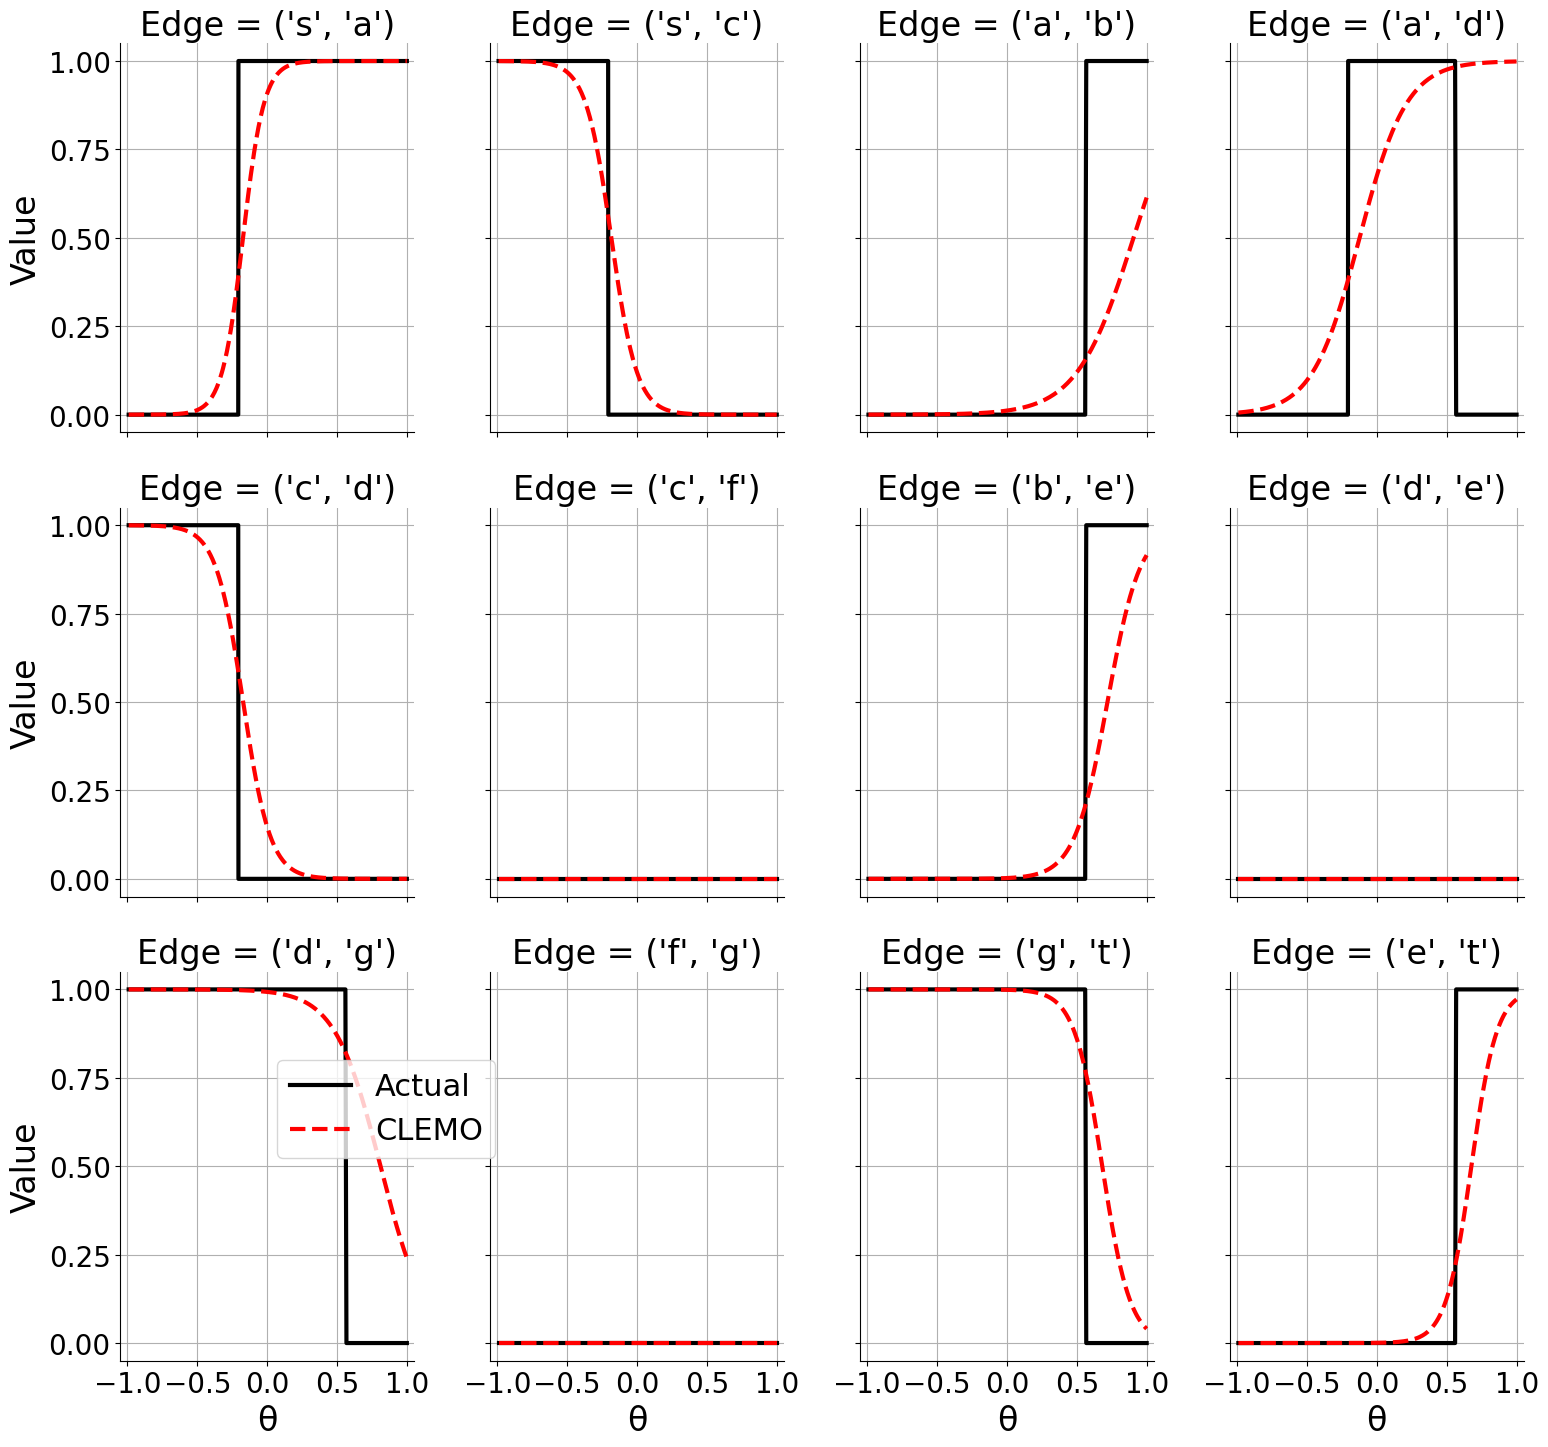

In [25]:
# Plot predictions decision variables in grid
data = []
plot_data = {}

plt.rcParams.update({
    'font.size': 24,              # Base font size
    'axes.labelsize': 24,         # Axis label size
    'xtick.labelsize': 20,        # X-tick label size
    'ytick.labelsize': 20,        # Y-tick label size
    'legend.fontsize': 22,        # Legend text size
})

# Generate data for each plot
for indx in all_trgs[:]:
    edge = str(edge_list[indx])
    x0_prd = sig(np.matmul(samples, beta_sol)[:,indx+1])
    x0_act = np.array(actuals)[:,indx+1]
    tuple = (x0_act, x0_prd)
    plot_data[edge] = tuple


# Create a long-format DataFrame
for plot_name, (line1, line2) in plot_data.items():
    # Add data for first line
    data.extend([
        {'\u03B8': x_val, 'Value': y_val, 'line': 'Actual', 'Edge': plot_name}
        for x_val, y_val in zip(lmb_smpls, line1)
    ])
    # Add data for second line
    data.extend([
        {'\u03B8': x_val, 'Value': y_val, 'line': 'Surrogate prediction', 'Edge': plot_name}
        for x_val, y_val in zip(lmb_smpls, line2)
    ])

# Convert to DataFrame
df = pd.DataFrame(data)

# Define custom color palette
custom_palette = {'Surrogate prediction': 'red',
                 'Actual': 'black'}     

# Create FacetGrid
g = sns.FacetGrid(df, col='Edge',
                  col_wrap=4, height=5, aspect = 0.8,
                  sharex=True, sharey=True)

# Custom plotting function to specify line styles
def plot_lines(data, x, y, hue, **kwargs):
    # Plot Line 1 with solid line and thickness of 2
    line1_data = data[data[hue] == 'Actual']
    sns.lineplot(data=line1_data, x=x, y=y, 
                color=custom_palette['Actual'],
                linestyle='-',    # solid line
                linewidth=3)      # thicker line
    
    # Plot Line 2 with dashed line and thickness of 1.5
    line2_data = data[data[hue] == 'Surrogate prediction']
    sns.lineplot(data=line2_data, x=x, y=y,
                color=custom_palette['Surrogate prediction'],
                linestyle='--',   # dashed line
                linewidth=3)    # medium thickness

# Map the custom plotting function
g.map_dataframe(plot_lines, x='\u03B8', y='Value', hue='line')

#  Create a single legend
legend_elements = [
    Line2D([0], [0], color=custom_palette['Actual'], linestyle='-', 
           linewidth=3, label='Actual'),
    Line2D([0], [0], color=custom_palette['Surrogate prediction'], linestyle='--', 
           linewidth=3, label='CLEMO')
]

# Add a single legend to the figure
g.fig.legend(handles=legend_elements, 
            loc='lower left' , bbox_to_anchor=(0.18, 0.2))  # Fine-tune the position

g.set(xlim=(-1.05, 1.05),    # Set x-axis limits
      ylim=(-0.05, 1.05))    # Set y-axis limits

ax = plt.gca()
ax.grid(True)

plt.gca().set_xticks(np.arange(-1, 1.1, 0.5))    # Every 2 units
plt.gca().set_yticks(np.arange(0, 1.1, 0.25))   # Every 2 units

# Remove individual legends from subplots
for ax in g.axes:
    ax.get_legend().remove() if ax.get_legend() else None
    ax.grid(True)

ax = plt.gca()
ax.grid(True)

# Adjust the layout with space for legend
plt.tight_layout()
# g.fig.subplots_adjust(right=0.85)  # Make room for legend

# Show the plot
plt.show()

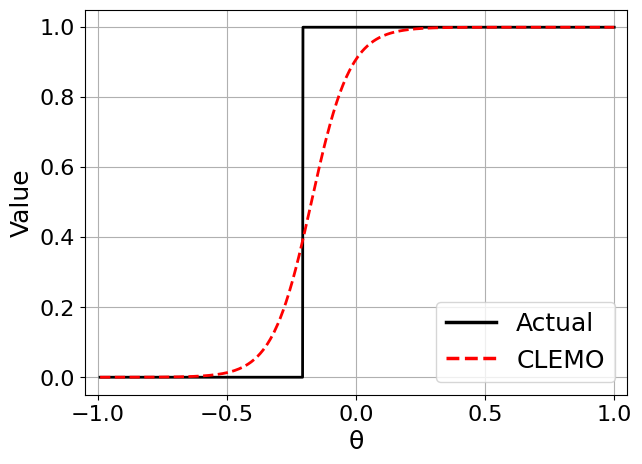

In [26]:
# Plot (s,a) prediction
edge = str(edge_list[0])
x0_prd = sig(np.matmul(samples, beta_sol)[:,1])
x0_act = np.array(actuals)[:,1]
tuple = (x0_act, x0_prd)
plot_data[edge] = tuple

fig = plt.figure(figsize=(7,5))
plt.rcParams.update({
    'font.size': 18,              # Base font size
    'axes.labelsize': 18,         # Axis label size
    'xtick.labelsize': 16,        # X-tick label size
    'ytick.labelsize': 16,        # Y-tick label size
    'legend.fontsize': 18,        # Legend text size
})
sns.lineplot(x=lmb_smpls, y=x0_act, 
                color='Black',
                linestyle='-',    # solid line
                linewidth=2)      # thicker line
    

sns.lineplot(x=lmb_smpls, y=x0_prd,
                color='Red',
                linestyle='--',   # dashed line
                linewidth=2)    # medium thickness

legend_elements = [
    Line2D([0], [0], color='Black', linestyle='-', 
           linewidth=2.5, label='Actual'),
    Line2D([0], [0], color='Red', linestyle='--', 
           linewidth=2.5, label='CLEMO')
]

ax = plt.gca()
ax.grid(True)
# Add a single legend to the figure
plt.legend(handles=legend_elements, 
            loc='lower right' )  # Fine-tune the position
plt.xlabel("\u03B8")
plt.ylabel("Value") 
plt.xlim(-1.05, 1.05)    # Set x-axis limits
# plt.ylim(16.5, 25)   # Set y-axis limits

plt.gca().set_xticks(np.arange(-1, 1.1, 0.5))    # Every 2 units
# plt.gca().set_yticks(np.arange(17, 25.1, 1))   # Every 2 units
# plt.title("Edge: "+edge +" prediction")
plt.show()